---
title: "Prefiltering data from PanUKB"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-01-30"
file-modified: "2024-02-26"
abstract: "We read the data from PanUKB and prefilter based on heritability and effect size."

---

In [53]:
import numpy as np
import pandas as pd
import pickle
import os
from scipy import stats as sc_stats

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
from nnwmf.utils import model_errors as merr

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

In [45]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/nnwmf"
zscore_filename = f"{data_dir}/GWAS_Zscore.tsv"
trait_filename = f"{data_dir}/trait_manifest_TableS6_no_readme.tsv"
zscore_df = pd.read_csv(zscore_filename, sep = '\t')
trait_df = pd.read_csv(trait_filename, sep = '\t')

# remove extra columns from trait_df

colnames = trait_df.columns.tolist()
colnames[0] = "zindex"
trait_df.columns = colnames
trait_df_mod = trait_df.drop(labels = ['coding', 'modifier', 'coding_description', 'filename', 'aws_link'], axis=1)
#trait_df_mod

In [46]:
trait_df_mod

,zindex,trait_type,phenocode,pheno_sex,description,description_more,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,estimates.final.h2_observed
0,1,icd10,A04,both_sexes,A04 Other bacterial intestinal infections,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,3088,417443.0,420531,6130.649032,0.0033
1,2,icd10,A08,both_sexes,A08 Viral and other specified intestinal infec...,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,1107,419424.0,420531,2208.171897,0.0001
2,3,icd10,A09,both_sexes,A09 Diarrhoea and gastro-enteritis of presumed...,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,9029,411502.0,420531,17670.286180,0.0035
3,4,icd10,A41,both_sexes,A41 Other septicaemia,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,5512,415019.0,420531,10879.505810,0.0011
4,5,icd10,B34,both_sexes,B34 Viral infection of unspecified site,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,2129,418402.0,420531,4236.443249,0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,2479,continuous,Smoking,both_sexes,"Smoking status, ever vs never",Ever (previous + current smoker) vs never base...,NaN,QT,418817,NaN,418817,418817.000000,0.1100
2479,2480,continuous,eGFR,both_sexes,"Estimated glomerular filtration rate, serum cr...",eGFR based on serum creatinine (30700) using t...,NaN,QT,401867,NaN,401867,401867.000000,0.2070
2480,2481,continuous,eGFRcreacys,both_sexes,"Estimated glomerular filtration rate, cystain C",eGFR based on cystain C (30720) using the CKD-...,NaN,QT,401570,NaN,401570,401570.000000,0.2380
2481,2482,continuous,eGFRcys,both_sexes,"Estimated glomerular filtration rate, serum cr...",eGFR based on serum creatinine (30700) and cys...,NaN,QT,402031,NaN,402031,402031.000000,0.2240


In [47]:
#| code-fold: false

zscore_df

,rsid,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,z2474,z2475,z2476,z2477,z2478,z2479,z2480,z2481,z2482,z2483
0,rs6657440,-0.903532,0.561842,0.711068,-0.109174,0.223668,-1.728199,0.374988,-0.265971,-2.823282,...,1.521092,0.612532,1.405428,0.018029,0.895337,-0.008761,-2.069432,-4.292948,-4.701711,2.952899
1,rs7418179,0.398166,1.163539,0.512118,0.144794,-1.313903,-1.547410,0.450270,0.560324,-1.502268,...,-0.296537,-0.734266,-0.093081,0.412077,1.961159,0.716049,-2.171984,-5.314085,-6.612137,3.817518
2,rs80125161,-1.739115,-0.172328,0.349145,-0.329335,-0.870640,-1.004155,1.128148,0.151244,-1.816075,...,2.222433,1.092969,2.328233,1.160767,0.909524,-1.467249,-0.135785,-2.187241,-3.223529,4.508578
3,rs7524174,-0.884478,-1.762000,1.312823,-0.550764,2.132540,0.519828,0.834194,0.699441,-0.885281,...,3.356354,1.990588,3.092179,-0.133810,-0.072845,-1.376310,1.317044,0.913491,0.535188,2.245657
4,rs3829740,-1.469931,-0.519628,-0.281605,-0.267729,-1.060167,0.058116,-0.638319,-0.589767,0.228514,...,-0.320075,-0.128047,-0.524757,-0.232900,-1.051020,-0.483644,2.026508,4.400092,5.407316,1.125536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51394,rs9616937,-0.211947,1.371231,-1.800776,0.609980,-0.619822,0.947269,-1.166021,0.478601,-0.359714,...,0.714167,0.354347,0.611158,-0.354725,1.073043,-0.831737,0.870924,1.432076,2.228501,0.536104
51395,rs1024374,0.027097,-1.817082,0.530216,0.813498,-0.076514,0.784427,1.411160,-1.111740,-0.224438,...,1.107098,1.482684,1.512723,0.322355,-0.374603,1.320194,-0.700092,-1.395039,-2.270186,0.360025
51396,rs144480800,0.545682,0.391830,0.520505,-1.280976,0.453876,-1.388940,0.025094,0.737788,1.178641,...,-0.562063,-1.148515,-0.994185,-0.268232,-0.069619,0.013256,-0.777667,-1.544760,-1.406344,2.205817
51397,rs5770994,1.441851,1.152368,-1.500000,-0.468137,-0.444156,-0.780139,-0.853550,-0.316097,0.311219,...,-1.185702,-0.624073,-0.859522,0.549669,1.809912,0.268733,0.947441,1.533302,1.658537,2.218653


In [48]:
h2_cut = 0.1
pval_cut = 5e-8

trait_df_selected = trait_df_mod[trait_df_mod['estimates.final.h2_observed'] > h2_cut]
zidx_selected = trait_df_selected['zindex'].values
colnames_selected = ['rsid'] + [f'z{x}' for x in zidx_selected]
zscore_df_selected = zscore_df[colnames_selected]
zcut = sc_stats.norm.ppf(1 - (pval_cut / 2))
rsid_idx_selected = []
for x in zidx_selected:
    rsid_idx_selected += zscore_df_selected[zscore_df_selected[f'z{x}'].abs() > zcut].index.to_list()
    
rsid_idx_selected = sorted(set(rsid_idx_selected))
zscore_df_selected = zscore_df_selected.iloc[rsid_idx_selected, :].drop(labels = ['rsid'], axis = 1)

In [49]:
X = np.array(zscore_df_selected.values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(np.isnan(X)) / np.prod(X_cent.shape):.3f}")

We have 216 samples (phenotypes) and 48212 features (variants)
Fraction of Nan entries: 0.000


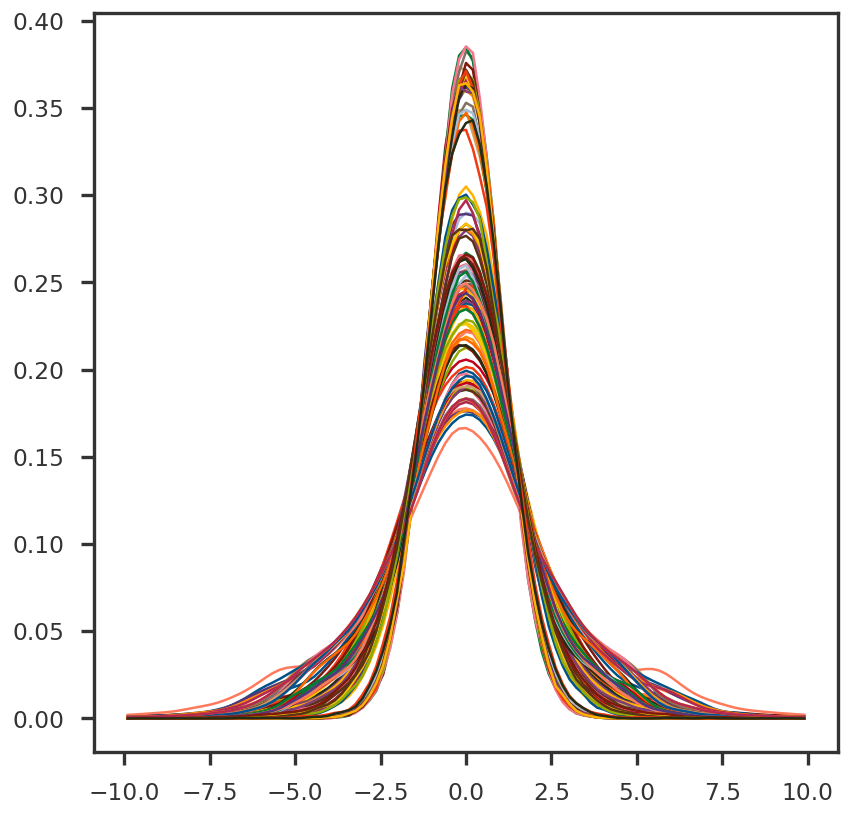

In [50]:
import scipy.stats as sc_stats

def get_density(x, data):
    density = sc_stats.gaussian_kde(data)
    return density.pdf(x)

def get_bins(data, nbin, xmin, xmax):
    xdelta = (np.max(data) - np.min(data)) / 10
    if not xmin: xmin = np.min(data) - xdelta
    if not xmax: xmax = np.max(data) + xdelta
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    return xmin, xmax, bins, xbin

fig = plt.figure()
ax1 = fig.add_subplot(111)

for n in range(100):
    scores_cent = X_cent[n, :]
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, -10, 10)
    curve = get_density(xbin, scores_cent)
    ax1.plot(xbin, curve)

plt.show()

# Hierarchical clustering of covariance matrix

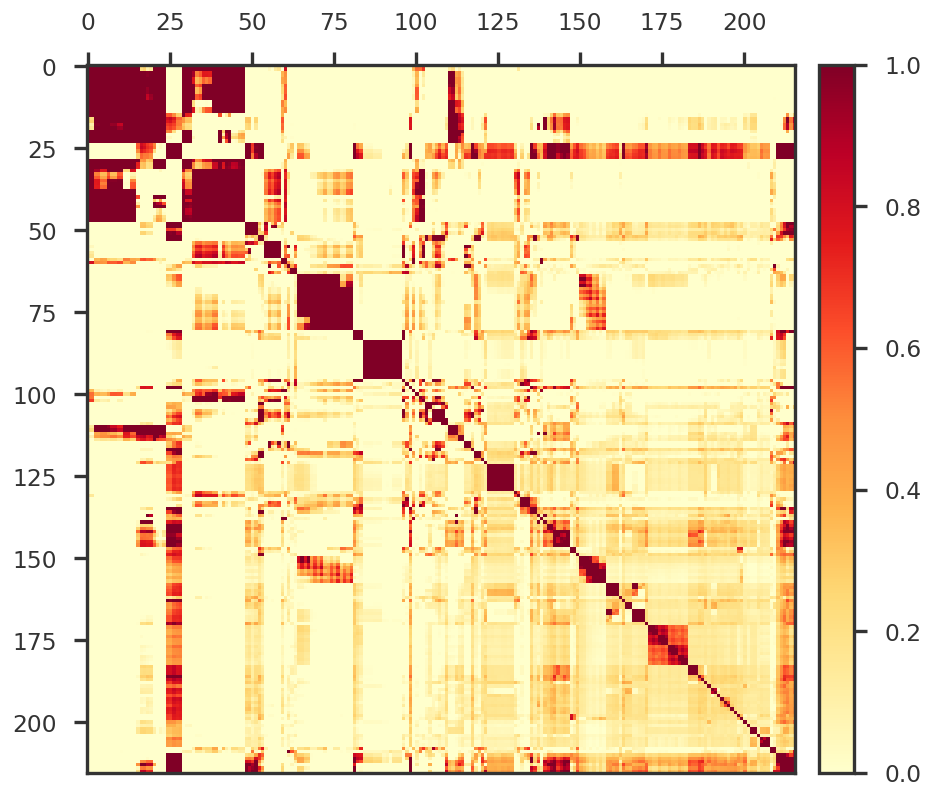

In [51]:
from scipy.cluster import hierarchy as sp_hierarchy

sample_distance_matrix = np.cov(X_cent)
o1 = sp_hierarchy.leaves_list(sp_hierarchy.linkage(sample_distance_matrix, method = 'centroid'))

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
                                            
#mpy_plotfn.plot_covariance_heatmap(ax1, Z * np.sqrt(p) / np.sqrt(nsample))
mpy_plotfn.plot_covariance_heatmap(ax1, X_cent[o1, :])

plt.tight_layout()
plt.show()

# Save the dataframes

In [54]:
zscore_df_selected_filename = os.path.join(data_dir, f"modselect/zscore_h2{h2_cut}_pval{pval_cut}.pkl")
trait_df_selected_filename  = os.path.join(data_dir, f"modselect/traits_h2{h2_cut}.pkl")

zscore_df_selected.to_pickle(zscore_df_selected_filename)
trait_df_selected.to_pickle(trait_df_selected_filename)

## Generate a masked input

In [28]:
def generate_masked_input(Y, mask):
    Ymiss_nan = Y.copy()
    Ymiss_nan[mask] = np.nan
    Ymiss_nan_cent = Ymiss_nan - np.nanmean(Ymiss_nan, axis = 0, keepdims = True)
    Ymiss_nan_cent[mask] = 0.0
    return Ymiss_nan_cent

def generate_mask(n, p, ratio):
    mask = np.ones(n * p)
    nzero = int(ratio * n * p)
    mask[:nzero] = 0.0
    np.random.shuffle(mask)
    return mask.reshape(n,p) == 0.

Z_mask = generate_mask(X.shape[0], X.shape[1], 0.2)
Z_cent = generate_masked_input(X_cent, Z_mask)

In [29]:
def root_mean_squared_error(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    n = np.sum(mask)
    mse = np.sum(np.square((original - recovered) * mask)) / n
    return np.sqrt(mse)

In [30]:
root_mean_squared_error(X_cent, Z_cent, mask = Z_mask)

1.99756722409535

In [31]:
oracle_pred = X_cent.copy()
oracle_pred[~Z_mask] = 0.0
root_mean_squared_error(X_cent, oracle_pred, mask = Z_mask)

0.0

# RPCA - IALM

In [34]:
rpca_model = IALM(max_iter = 10000, mu_update_method='admm', show_progress = True, print_skip = 100)
rpca_model.fit(Z_cent, mask = Z_mask)

2024-02-23 13:13:17,128 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0046)
2024-02-23 13:13:20,398 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.904981. Dual residual 0.000129418
2024-02-23 13:16:14,617 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 100. Primal residual 5.08002e-06. Dual residual 4.58555e-06
2024-02-23 13:19:08,475 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 200. Primal residual 9.00645e-07. Dual residual 9.55942e-07
2024-02-23 13:22:02,621 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 300. Primal residual 2.24024e-07. Dual residual 2.41075e-07


In [37]:
print ("Nuclear Norms")
print (f"Original matrix: {np.linalg.norm(X, 'nuc')}")
print (f"Original matrix centered: {np.linalg.norm(X_cent, 'nuc')}")
print (f"Masked matrix: {np.linalg.norm(Z_cent, 'nuc')}")
print (f"Recovered matrix: {np.linalg.norm(rpca_model.L_, 'nuc')}")

Nuclear Norms
Original matrix: 56014.783744890694
Original matrix centered: 55147.50855870614
Masked matrix: 64158.87521360069
Recovered matrix: 18790.550737035624


In [38]:
root_mean_squared_error(X_cent, rpca_model.L_, mask = Z_mask)

1.9975672115686012

# NNM

In [20]:
rank_opt = 4096.
nnm_model = FrankWolfe(model = 'nnm', max_iter = 10000, svd_max_iter = 50, show_progress = True, print_skip = 100)
nnm_model.fit(Z_cent, rank_opt, mask = Z_mask)

2024-02-13 10:41:55,467 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.429. Duality Gap 7.1954e+06
2024-02-13 10:47:13,083 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 100. Step size 0.008. Duality Gap 137328
2024-02-13 10:51:56,111 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 200. Step size 0.003. Duality Gap 57230.8
2024-02-13 10:56:39,601 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 300. Step size 0.003. Duality Gap 36125.2


In [28]:
root_mean_squared_error(X_cent, nnm_model.X, mask = Z_mask)

1.8754185985095613

In [37]:
nseq  = int(np.floor(np.log2(rmax)) + 1) + 1
rseq = np.logspace(9, nseq - 1, num = nseq - 9, base = 2.0)
rseq

array([  512.,  1024.,  2048.,  4096.,  8192., 16384.])

In [40]:
nnm_model = {
    x: FrankWolfe(model = 'nnm', max_iter = 10000, 
                  svd_max_iter = 50, show_progress = True, print_skip = 100) for x in rseq}
nnm_model[512] = nnm_model_

In [44]:
for i, rank in enumerate(rseq):
    if i > 0:
        prev_rank = rseq[i-1]
        nnm_model[rank].fit(Z_cent, rank, mask = Z_mask, X0 = nnm_model[prev_rank].X)

2024-01-31 14:25:22,378 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 945157
2024-01-31 14:25:59,659 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-31 14:26:29,154 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.385. Duality Gap 1.5822e+06
2024-01-31 14:33:32,767 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-31 14:33:47,967 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-31 14:36:17,084 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-31 14:37:01,744 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-31 14:37:09,216 | nnwmf.optimize.frankwolfe                | WARNIN

KeyboardInterrupt: 

In [47]:
for i, rank in enumerate(rseq[:4]):
    nnm_rmse = root_mean_squared_error(X_cent, nnm_model[rank].X, mask = Z_mask)
    print (rank, nnm_rmse)

512.0 1.9266675901879784
1024.0 1.8749317132652092
2048.0 1.7887138061073196
4096.0 1.6675354537614655


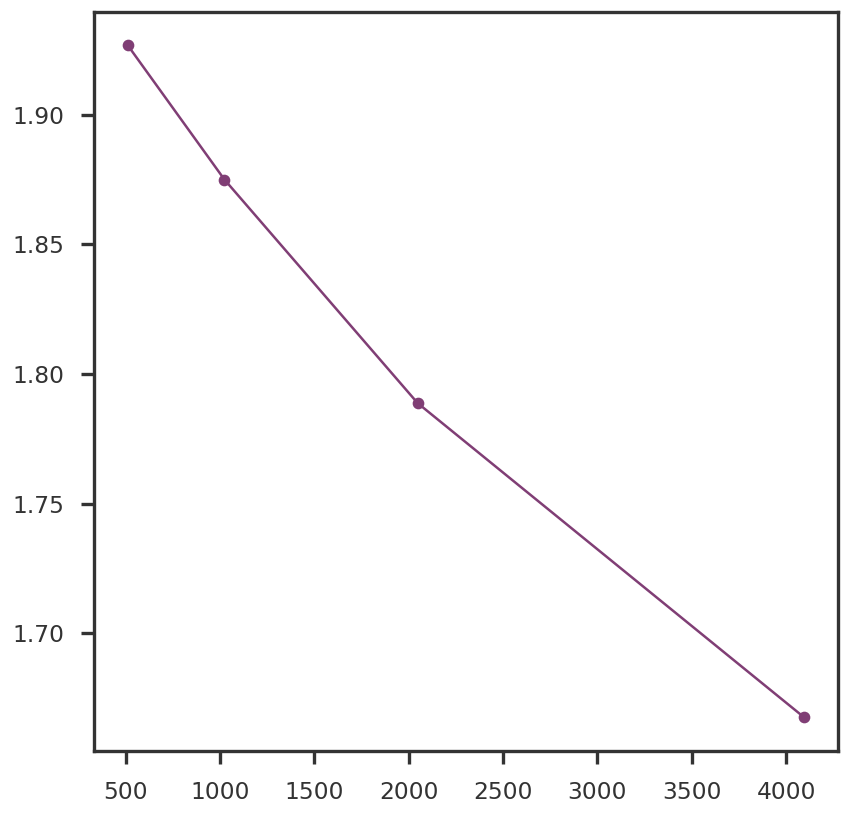

In [48]:
fig = plt.figure()
ax1 = fig.add_subplot()
xvals = rseq[:4]
yvals = [root_mean_squared_error(X_cent, nnm_model[x].X, mask = Z_mask) for x in xvals]
ax1.plot(xvals, yvals, marker = 'o')
plt.show()

# NNM-Sparse

In [40]:
nnm_sparse_model = FrankWolfe(model = 'nnm-sparse', max_iter = 10000, svd_max_iter = 50, show_progress = True)
nnm_sparse_model.fit(Z_cent, (rank_opt, 0.5), mask = Z_mask)

2024-01-25 11:22:28,201 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.468. Duality Gap 491221


In [43]:
print ("Nuclear Norms")
print (f"Recovered matrix (NNM): {np.linalg.norm(nnm_model.X, 'nuc')}")
print (f"Recovered matrix (NNM-Sparse): {np.linalg.norm(nnm_sparse_model.X, 'nuc')}")

Nuclear Norms
Recovered matrix (NNM): 1015.0879690877024
Recovered matrix (NNM-Sparse): 1014.317846484247


In [ ]:
from scipy.spatial import procrustes

def mean_squared_error(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    n = np.sum(mask)
    mse = np.sum(np.square((original - recovered) * mask)) / n
    return mse


def peak_signal_to_noise_ratio(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    omax = np.max(original[mask == 1])
    omin = np.min(original[mask == 1])
    maxsig2 = np.square(omax - omin)
    mse = mean_squared_error(original, recovered, mask)
    res = 10 * np.log10(maxsig2 / mse)
    return res


def matrix_dissimilarity_scores(original, recovered, mask = None):
    '''
    Procrustes analysis returns the square of the Frobenius norm.
    Use the rotated matrix to obtain the peak signal-to-noise ratio (PSNR).
    '''
    k = min(original.shape[1], recovered.shape[1])
    R_orig, R_recv, m2 = procrustes(original[:, 0:k], recovered[:, 0:k])
    psnr = peak_signal_to_noise_ratio(R_orig, R_recv, mask)
    rmse = np.sqrt(mean_squared_error(R_orig, R_recv, mask))
    return rmse, psnr

print ("RMSE")
orig_rmse, orig_psnr = matrix_dissimilarity_scores(X_cent, Z_cent, Z_mask)
rpca_rmse, rpca_psnr = matrix_dissimilarity_scores(X_cent, rpca_model.L_, Z_mask)
nnm_rmse, nnm_psnr = matrix_dissimilarity_scores(X_cent, nnm_model[4096].X, Z_mask)
#nnm_sparse_rmse, nnm_sparse_psnr = matrix_dissimilarity_scores(X_cent, nnm_sparse_model.X, Z_mask)

print (f"Zero: {orig_rmse:g}")
print (f"RPCA: {rpca_rmse:g}")
print (f"NNM: {nnm_rmse:g}")
print (f"NNM-Sparse: {nnm_sparse_rmse:g}")

RMSE


In [52]:
print ("RMSE")
print (f"Zero prediction: {orig_rmse:g}")
print (f"RPCA: {rpca_rmse:g}")
print (f"NNM: {nnm_rmse:g}")
print (f"NNM-Sparse: {nnm_sparse_rmse:g}")
print("")
print ("PSNR")
print (f"Zero prediction: {orig_psnr:g}")
print (f"RPCA: {rpca_psnr:g}")
print (f"NNM: {nnm_psnr:g}")
print (f"NNM-Sparse: {nnm_sparse_psnr:g}")

RMSE
Zero prediction: 8.9478e-05
RPCA: 0.000446309
NNM: 0.000407213
NNM-Sparse: 0.000407142

PSNR
Zero prediction: 56.9045
RPCA: 42.9461
NNM: 43.7424
NNM-Sparse: 43.7439


In [49]:
zero_rmse, zero_psnr = matrix_dissimilarity_scores(X_cent, X, Z_mask)

RMSE


In [50]:
zero_rmse

3.859249487545338e-15

In [51]:
zero_psnr

264.2087877109133